# freud.diffraction.StaticStructureFactorDirect and freud.diffraction.StaticStructureFactorDebye

The `freud.diffraction` module provides two methods for calculating a one-dimensional [static structure factor](https://en.wikipedia.org/wiki/Structure_factor) $S(k)$ which can be used to characterize structure of crystals, liquids or amorphous phases.

The `freud.diffraction.StaticStructureFactorDirect` class implements a "direct" $S(k)$ method. First, the following expression is computed over a $k$-space (reciprocal space) grid:

$$S(\vec{k}) = {\frac{1}{N}}\sum_{i=1}^{N}\sum_{j=1}^{N}\mathrm{e}^{-i\vec{k}\cdot(\vec{r}_{i} - \vec{r}_{j})}$$

Then, the angular dependence is integrated out, resulting in $S(|\vec{k}|)$, otherwise denoted $S(k)$. For an excellent introduction to the theory of scattering and $S(k)$, please refer to the documentation of the [dynasor package](https://dynasor.materialsmodeling.org/), which performs a number of calculations related to scattering. The **freud** library implements the core method of static structure factor calculation based on the dynasor package, with some additional performance optimizations in parallelized C++ code, as well as an interface to compute $S(k)$ that aligns with the APIs and conventions of the **freud** library.

The `freud.diffraction.StaticStructureFactorDebye` class computes static structure factor based on the Debye scattering equation:

$$ S(k) = {\frac{1}{N}} \sum_{i=1}^{N}\sum_{j=1}^{N}{\frac{\sin(kr_{ij})}{kr_{ij}}} $$

which is obtained by integrating out the angular dependence from the original formula. This implementation provides a much faster algorithm, but gives worse results than the "direct" method at low $k$ values.

Note that freud employs the usual physics convention, as opposed to the crystallographic convention, with the following expression linking the two: $k = 2\pi q$. The static structure factor is related to the radial distribution function, $g(r)$, by a Fourier Transform:

$$S(k) = 1 + \rho \int_{V}\mathrm{d}\vec{r}e^{-i\vec{k}\cdot\vec{r}}g(r). $$

## Lennard-Jones Liquid Example

One of the use cases for $S(k)$ is to characterize structure of liquids. The example shown here uses data generated by a HOOMD-blue simulation of a 1000 particle system subject to the Lennard-Jones potential. See the HOOMD-blue [documentation](https://hoomd-blue.readthedocs.io/en/latest/) and [examples](https://github.com/glotzerlab/hoomd-examples) for more information.

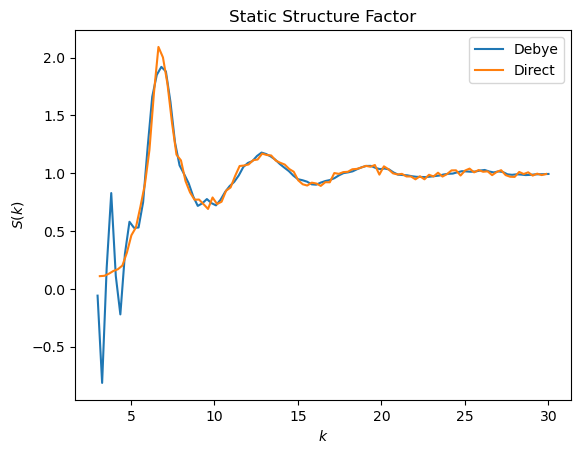

In [1]:
import freud
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np

bins = 100
k_max = 30
k_min = 3
sfDirect = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)
sfDebye = freud.diffraction.StaticStructureFactorDebye(
    num_k_values=bins, k_max=k_max, k_min=k_min
)

with gsd.hoomd.open("data/LJsampletraj.gsd", "r") as traj:
    for frame in traj:
        sfDebye.compute(frame, reset=False)
        sfDirect.compute(frame, reset=False)

plt.plot(sfDebye.k_values, sfDebye.S_k, label="Debye")
plt.plot(sfDirect.bin_centers, sfDirect.S_k, label="Direct")
plt.title("Static Structure Factor")
plt.xlabel("$k$")
plt.ylabel("$S(k)$")
plt.legend()
plt.show()

## Crystal Comparison Example

The static structure factor $S(k)$ can also be used to characterize and compare crystal structures. In the below example we compare the computed static structure factors $S(k)$ of a face-centered cubic (fcc) crystal and simple cubic (sc) crystal.

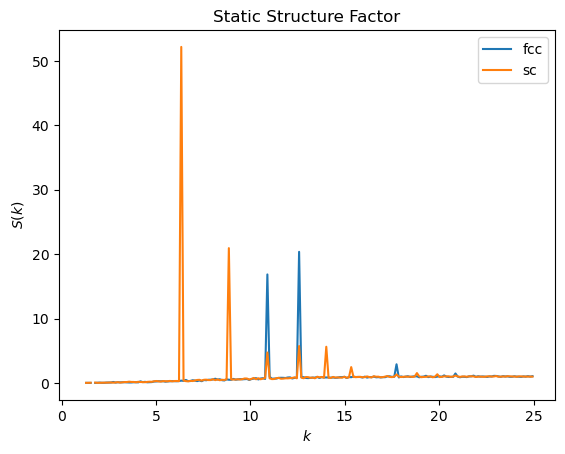

In [2]:
sf = freud.diffraction.StaticStructureFactorDirect(bins=200, k_max=25, k_min=1)
fcc_system = freud.data.UnitCell.fcc().generate_system(10, sigma_noise=0.10)
sf.compute(fcc_system)
plt.plot(sf.bin_centers, sf.S_k, label="fcc")

sc_system = freud.data.UnitCell.sc().generate_system(10, sigma_noise=0.10)
sf.compute(sc_system)
plt.plot(sf.bin_centers, sf.S_k, label="sc")

plt.title("Static Structure Factor")
plt.xlabel("$k$")
plt.ylabel("$S(k)$")
plt.legend()
plt.show()

## Calculation of Partial Structure Factors

Both methods support calculation of partial structure factors according to [Faber-Ziman decomposition](https://freud.readthedocs.io/en/latest/modules/diffraction.html#freud.diffraction.StaticStructureFactorDirect). In the conventions adopted in **freud**, the summation of partials reproduces the total scattering. In this example we load a simulation trajectory of $\text{GeS}_2$ and calculate the Ge-Ge partial, the S-S partial and the mixed Ge-S partial (which is the same as S-Ge partial). The calculation of the partials requires the usage of `query_points` and `N_total` parameters for the compute method.

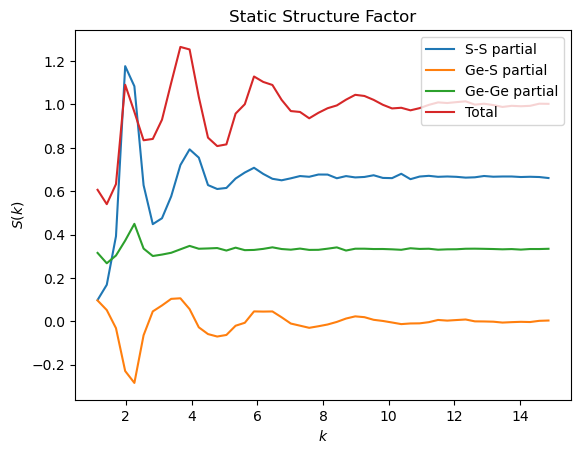

In [3]:
import freud
import matplotlib.pyplot as plt
import numpy as np

# read in xyz file
# read number of particles
N_particles = int(np.genfromtxt("data/ges2.xyz", max_rows=1, dtype=int))
cleaned_data = []
# remove lines that don't contain particle data
with open("data/ges2.xyz") as f:
    for line in f:
        if line[0] != "\n" and line[0] != " ":
            cleaned_data.append(line)

positions = np.genfromtxt(cleaned_data)[:, 1:4].reshape(-1, N_particles, 3)
particle_types = np.genfromtxt(cleaned_data, dtype=str)[:, 0].reshape(-1, N_particles)

box = freud.Box.cube(19.21)

# max_k_points is the number of k-points used in the calculation,
# higher values give better S(k) but takes longer
k_max = 15
k_min = 1
bins = 50
sfGe_Ge = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)
sfGe_S = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)
sfS_S = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)
sfTotal = freud.diffraction.StaticStructureFactorDirect(
    bins=bins, k_max=k_max, k_min=k_min
)

for frame_positions, frame_types in zip(positions, particle_types):
    Ge_positions = frame_positions[frame_types == "Ge"]
    S_positions = frame_positions[frame_types == "S"]
    sfGe_Ge.compute(
        (box, Ge_positions),
        query_points=Ge_positions,
        N_total=N_particles,
        reset=False,
    )
    sfGe_S.compute(
        (box, S_positions),
        query_points=Ge_positions,
        N_total=N_particles,
        reset=False,
    )
    sfS_S.compute(
        (box, S_positions),
        query_points=S_positions,
        N_total=N_particles,
        reset=False,
    )
    sfTotal.compute(
        (box, frame_positions),
        reset=False,
    )

plt.plot(sfS_S.bin_centers, sfS_S.S_k, label="S-S partial")
plt.plot(sfGe_S.bin_centers, sfGe_S.S_k, label="Ge-S partial")
plt.plot(sfGe_Ge.bin_centers, sfGe_Ge.S_k, label="Ge-Ge partial")

# Note that the Ge-S partial must be included twice
S_tot = sfS_S.S_k + 2 * sfGe_S.S_k + sfGe_Ge.S_k
assert np.allclose(S_tot, sfTotal.S_k, atol=1e-5, rtol=1e-5)

plt.plot(sfGe_Ge.bin_centers, S_tot, label="Total")
plt.title("Static Structure Factor")
plt.xlabel("$k$")
plt.ylabel("$S(k)$")
plt.legend(loc="upper right")
plt.show()

To ensure that our computed partial structure factors are consistent with the overall normalization of the total structure factor, we can adopt an alternative normalization scheme. In this approach, each partial structure factor is reweighted so that, in the large‑𝑞 (high wavevector) limit, they all converge to unity—just like the total structure factor. This normalization is particularly useful when comparing simulation data with experimental results, as it guarantees that the asymptotic behavior of the partials is in line with the expected long‑𝑞 behavior.

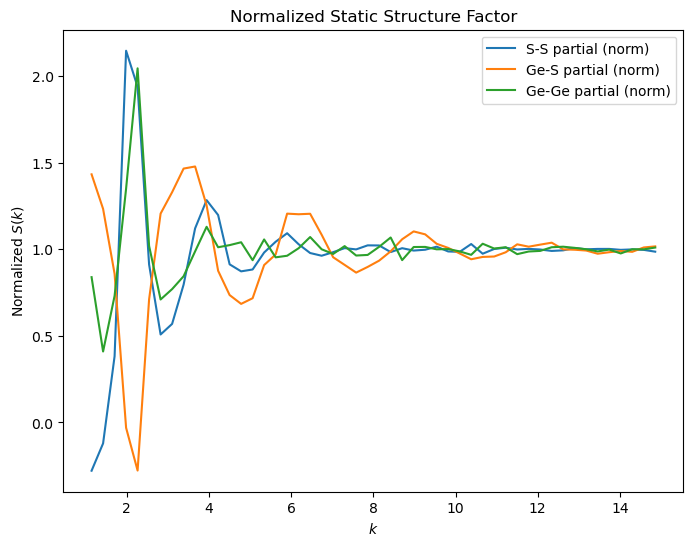

In [4]:
# Now compute the mole fractions from the first frame
x_Ge = np.sum(particle_types[0] == "Ge") / N_particles
x_S = np.sum(particle_types[0] == "S") / N_particles

# Normalize the partial S(k) so that it approaches 1.
S_Ge_Ge_norm = sfGe_Ge.S_k / (x_Ge**2) + 1 - 1 / x_Ge
S_S_S_norm = sfS_S.S_k / (x_S**2) + 1 - 1 / x_S
S_Ge_S_norm = sfGe_S.S_k / (x_Ge * x_S) + 1

# Plot the normalized S(k) partials
plt.figure(figsize=(8, 6))
plt.plot(sfS_S.bin_centers, S_S_S_norm, label="S-S partial (norm)")
plt.plot(sfGe_S.bin_centers, S_Ge_S_norm, label="Ge-S partial (norm)")
plt.plot(sfGe_Ge.bin_centers, S_Ge_Ge_norm, label="Ge-Ge partial (norm)")
plt.title("Normalized Static Structure Factor")
plt.xlabel("$k$")
plt.ylabel("Normalized $S(k)$")
plt.legend(loc="upper right")
plt.show()